In [1]:
from hcmus.core import appconfig

2025-06-11 11:10:27.123 | INFO     | hcmus.core.appconfig:<module>:7 - Load DotEnv: True


In [2]:
import os
import json
import random
import cv2
import numpy as np
from PIL import Image

# Paths
train_annotations_path = '/Volumes/Cucumber/Projects/datasets/sku110k/train/annotations_train.json'
train_images_dir = '/Volumes/Cucumber/Projects/datasets/sku110k/train/images/'
zoom_annotations_path = '/Volumes/Cucumber/Projects/datasets/sku110k/zoom/annotations_zoom.json'
zoom_images_dir = '/Volumes/Cucumber/Projects/datasets/sku110k/zoom/images/'
zoom_factor_setting = (1.0, 3.0)
min_area_ratio = 0.3  # Minimum 30% of original area must be preserved

# Load the COCO annotations
with open(train_annotations_path, 'r') as f:
    train_annotations = json.load(f)

# Create the zoom directory if it doesn't exist
os.makedirs(zoom_images_dir, exist_ok=True)

# Function to randomly zoom and crop an image
def random_zoom_crop(image, zoom_factor, max_size=800):
    h, w = image.shape[:2]
    new_h, new_w = int(h / zoom_factor), int(w / zoom_factor)

    # Random corner selection
    corner = random.choice(['top_left', 'top_right', 'bottom_left', 'bottom_right'])
    if corner == 'top_left':
        x, y = 0, 0
    elif corner == 'top_right':
        x, y = w - new_w, 0
    elif corner == 'bottom_left':
        x, y = 0, h - new_h
    elif corner == 'bottom_right':
        x, y = w - new_w, h - new_h

    # Crop the image
    cropped_image = image[y:y+new_h, x:x+new_w]

    # Resize the image to max_size
    scale = min(max_size / cropped_image.shape[1], max_size / cropped_image.shape[0])
    resized_image = cv2.resize(cropped_image, (int(cropped_image.shape[1] * scale), int(cropped_image.shape[0] * scale)))

    return resized_image, (x, y, new_w, new_h, scale)

# Function to calculate intersection area between original bbox and crop region
def calculate_intersection_area(bbox, crop_x, crop_y, crop_w, crop_h):
    """Calculate the intersection area between bbox and crop region"""
    bbox_x, bbox_y, bbox_w, bbox_h = bbox

    # Calculate intersection bounds
    x1 = max(bbox_x, crop_x)
    y1 = max(bbox_y, crop_y)
    x2 = min(bbox_x + bbox_w, crop_x + crop_w)
    y2 = min(bbox_y + bbox_h, crop_y + crop_h)

    # If no intersection, return 0
    if x1 >= x2 or y1 >= y2:
        return 0

    return (x2 - x1) * (y2 - y1)

# Function to update bounding boxes and check area ratio
def update_bbox_with_filter(bbox, crop_info, min_ratio=0.3):
    x, y, new_w, new_h, scale = crop_info
    original_area = bbox[2] * bbox[3]

    # Calculate intersection area with crop region
    intersection_area = calculate_intersection_area(bbox, x, y, new_w, new_h)

    # Check if intersection area meets minimum ratio requirement
    if intersection_area < original_area * min_ratio:
        return None  # Filter out this bbox

    # Update bbox coordinates
    updated_bbox = [
        (bbox[0] - x) * scale,
        (bbox[1] - y) * scale,
        bbox[2] * scale,
        bbox[3] * scale
    ]

    # Additional check: ensure the updated bbox is still within reasonable bounds
    # and has meaningful dimensions after scaling
    if updated_bbox[2] < 5 or updated_bbox[3] < 5:  # Too small after scaling
        return None

    return updated_bbox

# Process each image in the train set
zoom_annotations = {'images': [], 'annotations': [], 'categories': train_annotations['categories']}
skipped_images = 0
total_boxes_before = 0
total_boxes_after = 0

for image_info in train_annotations['images']:
    image_path = os.path.join(train_images_dir, image_info['file_name'])
    image = cv2.imread(image_path)

    if image is None:
        print(f"Warning: Could not load image {image_path}")
        continue

    # Random zoom factor
    zoom_factor = random.uniform(*zoom_factor_setting)

    # Apply random zoom and crop
    zoomed_image, crop_info = random_zoom_crop(image, zoom_factor)

    # Collect valid annotations for this image
    valid_annotations = []
    image_boxes_before = 0

    for ann in train_annotations['annotations']:
        if ann['image_id'] == image_info['id']:
            image_boxes_before += 1
            updated_bbox = update_bbox_with_filter(ann['bbox'], crop_info, min_area_ratio)

            if updated_bbox is not None:
                updated_ann = ann.copy()
                updated_ann['bbox'] = updated_bbox
                # Update area as well
                updated_ann['area'] = updated_bbox[2] * updated_bbox[3]
                valid_annotations.append(updated_ann)

    # Only save the image if it has at least one valid annotation
    if valid_annotations:
        # Save the zoomed image
        zoomed_image_name = f"zoomed_{image_info['file_name']}"
        cv2.imwrite(os.path.join(zoom_images_dir, zoomed_image_name), zoomed_image)

        # Update image info
        zoomed_image_info = image_info.copy()
        zoomed_image_info['file_name'] = zoomed_image_name
        zoomed_image_info['width'] = zoomed_image.shape[1]
        zoomed_image_info['height'] = zoomed_image.shape[0]
        zoom_annotations['images'].append(zoomed_image_info)

        # Add valid annotations
        zoom_annotations['annotations'].extend(valid_annotations)

        total_boxes_before += image_boxes_before
        total_boxes_after += len(valid_annotations)
    else:
        skipped_images += 1
        print(f"Skipped image {image_info['file_name']} - no valid boxes after filtering")

# Save the new annotations
with open(zoom_annotations_path, 'w') as f:
    json.dump(zoom_annotations, f)

print(f"Processing complete!")
print(f"Total images processed: {len(train_annotations['images'])}")
print(f"Images with valid annotations: {len(zoom_annotations['images'])}")
print(f"Images skipped (no valid boxes): {skipped_images}")
print(f"Total boxes before filtering: {total_boxes_before}")
print(f"Total boxes after filtering: {total_boxes_after}")
print(f"Box retention rate: {total_boxes_after/total_boxes_before*100:.1f}%")
print(f"Zoomed images and annotations saved to {zoom_images_dir} and {zoom_annotations_path}")

Skipped image train_104.jpg - no valid boxes after filtering
Skipped image train_1074.jpg - no valid boxes after filtering
Skipped image train_1086.jpg - no valid boxes after filtering
Skipped image train_11.jpg - no valid boxes after filtering
Skipped image train_1165.jpg - no valid boxes after filtering
Skipped image train_1180.jpg - no valid boxes after filtering


Corrupt JPEG data: premature end of data segment


Skipped image train_1305.jpg - no valid boxes after filtering
Skipped image train_1660.jpg - no valid boxes after filtering
Skipped image train_1798.jpg - no valid boxes after filtering
Skipped image train_2087.jpg - no valid boxes after filtering


Corrupt JPEG data: bad Huffman code


Skipped image train_2611.jpg - no valid boxes after filtering
Skipped image train_2672.jpg - no valid boxes after filtering
Skipped image train_2709.jpg - no valid boxes after filtering


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


Skipped image train_3018.jpg - no valid boxes after filtering
Skipped image train_3029.jpg - no valid boxes after filtering


Corrupt JPEG data: bad Huffman code


Skipped image train_323.jpg - no valid boxes after filtering


Corrupt JPEG data: bad Huffman code
Premature end of JPEG file


Skipped image train_3553.jpg - no valid boxes after filtering


Premature end of JPEG file
Corrupt JPEG data: premature end of data segment


Skipped image train_3600.jpg - no valid boxes after filtering
Skipped image train_3622.jpg - no valid boxes after filtering
Skipped image train_3628.jpg - no valid boxes after filtering
Skipped image train_3790.jpg - no valid boxes after filtering


Corrupt JPEG data: 12658 extraneous bytes before marker 0xd2


Skipped image train_3806.jpg - no valid boxes after filtering


Corrupt JPEG data: 102 extraneous bytes before marker 0xd9


Skipped image train_3999.jpg - no valid boxes after filtering
Skipped image train_4079.jpg - no valid boxes after filtering


Premature end of JPEG file


Skipped image train_4246.jpg - no valid boxes after filtering
Skipped image train_4354.jpg - no valid boxes after filtering
Skipped image train_4396.jpg - no valid boxes after filtering
Skipped image train_4427.jpg - no valid boxes after filtering
Skipped image train_4436.jpg - no valid boxes after filtering
Skipped image train_461.jpg - no valid boxes after filtering
Skipped image train_4838.jpg - no valid boxes after filtering
Skipped image train_4880.jpg - no valid boxes after filtering
Skipped image train_4963.jpg - no valid boxes after filtering


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 562 extraneous bytes before marker 0xd9
Corrupt JPEG data: 572 extraneous bytes before marker 0xd9


Skipped image train_5152.jpg - no valid boxes after filtering
Skipped image train_5169.jpg - no valid boxes after filtering


Corrupt JPEG data: 41 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Skipped image train_5842.jpg - no valid boxes after filtering
Skipped image train_5888.jpg - no valid boxes after filtering
Skipped image train_5971.jpg - no valid boxes after filtering


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


Skipped image train_6161.jpg - no valid boxes after filtering
Skipped image train_6216.jpg - no valid boxes after filtering
Skipped image train_6332.jpg - no valid boxes after filtering


Corrupt JPEG data: bad Huffman code


Skipped image train_6498.jpg - no valid boxes after filtering
Skipped image train_6612.jpg - no valid boxes after filtering


Corrupt JPEG data: 405 extraneous bytes before marker 0xd9


Skipped image train_6733.jpg - no valid boxes after filtering


Corrupt JPEG data: bad Huffman code


Skipped image train_680.jpg - no valid boxes after filtering
Skipped image train_708.jpg - no valid boxes after filtering
Skipped image train_7125.jpg - no valid boxes after filtering
Skipped image train_7268.jpg - no valid boxes after filtering


Corrupt JPEG data: 96 extraneous bytes before marker 0xd9


Skipped image train_7396.jpg - no valid boxes after filtering
Skipped image train_74.jpg - no valid boxes after filtering
Skipped image train_7430.jpg - no valid boxes after filtering
Skipped image train_7440.jpg - no valid boxes after filtering
Skipped image train_7520.jpg - no valid boxes after filtering


Corrupt JPEG data: premature end of data segment


Skipped image train_7584.jpg - no valid boxes after filtering
Skipped image train_7609.jpg - no valid boxes after filtering


Corrupt JPEG data: bad Huffman code


Skipped image train_7645.jpg - no valid boxes after filtering


Corrupt JPEG data: bad Huffman code


Skipped image train_7880.jpg - no valid boxes after filtering


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4086 extraneous bytes before marker 0xd9
Corrupt JPEG data: 270 extraneous bytes before marker 0xd9


Skipped image train_8021.jpg - no valid boxes after filtering
Skipped image train_807.jpg - no valid boxes after filtering


Corrupt JPEG data: premature end of data segment


Skipped image train_8173.jpg - no valid boxes after filtering
Skipped image train_8191.jpg - no valid boxes after filtering
Skipped image train_8199.jpg - no valid boxes after filtering
Skipped image train_826.jpg - no valid boxes after filtering
Skipped image train_845.jpg - no valid boxes after filtering


Premature end of JPEG file
Corrupt JPEG data: premature end of data segment
Premature end of JPEG file


Processing complete!
Total images processed: 8219
Images with valid annotations: 8155
Images skipped (no valid boxes): 64
Total boxes before filtering: 1201264
Total boxes after filtering: 439648
Box retention rate: 36.6%
Zoomed images and annotations saved to /Volumes/Cucumber/Projects/datasets/sku110k/zoom/images/ and /Volumes/Cucumber/Projects/datasets/sku110k/zoom/annotations_zoom.json


In [7]:
import json
from hcmus.utils.viz_utils import draw_boxes
from PIL import Image
from hcmus.utils import viz_utils
annotations_path = "/Volumes/Cucumber/Projects/datasets/sku110k/zoom/annotations_zoom.json"
images_path = "/Volumes/Cucumber/Projects/datasets/sku110k/zoom/images"
annotations = json.load(open(annotations_path))

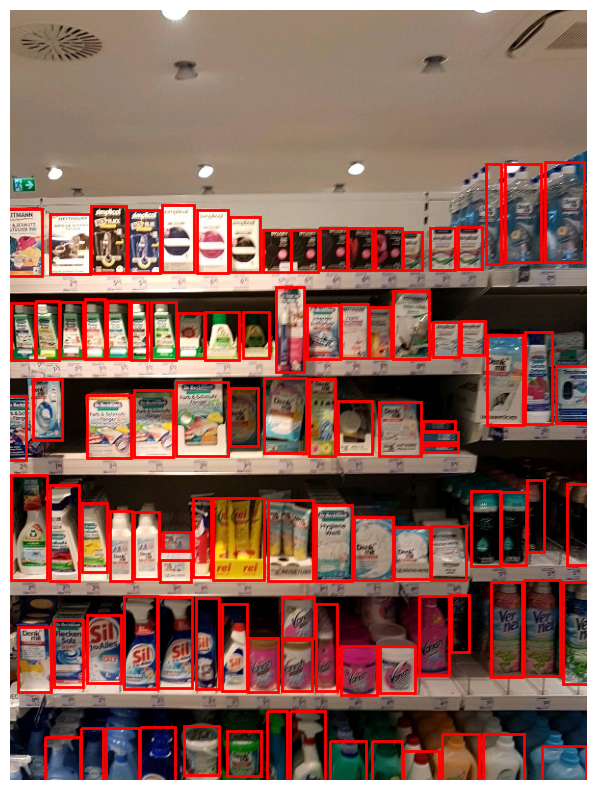

In [19]:
idx = 1230
image_idx = annotations.get("images")[idx]
image_path = images_path + "/" + image_idx.get("file_name")
image = Image.open(image_path)
boxes = []
for a in annotations.get("annotations"):
    if a.get("image_id") == image_idx.get("id"):
        bbox = a.get("bbox")
        bbox[2] = bbox[0] + bbox[2]
        bbox[3] = bbox[1] + bbox[3]
        boxes.append(a.get("bbox"))
viz_utils.draw_boxes(image, boxes)

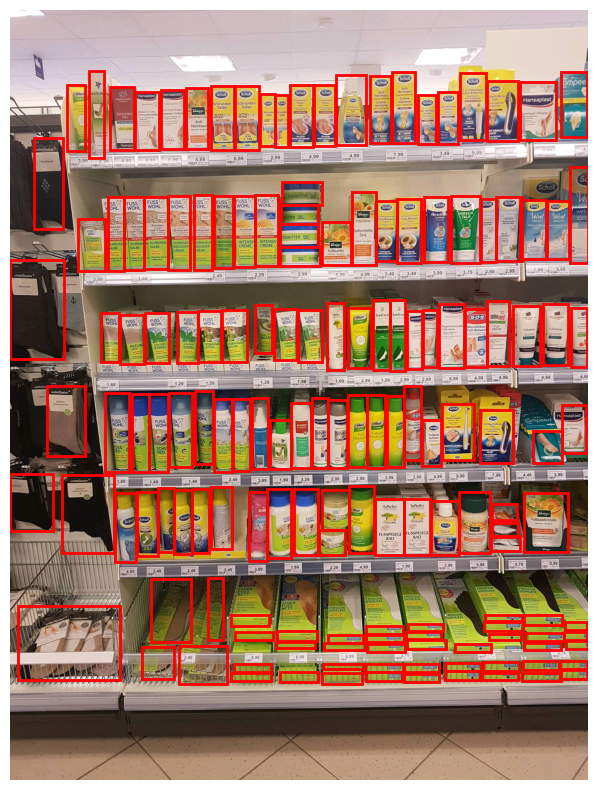

In [5]:
from PIL import Image
from hcmus.utils import viz_utils
annotations_path = "/Volumes/Cucumber/Projects/datasets/sku110k/train/annotations_train.json"
images_path = "/Volumes/Cucumber/Projects/datasets/sku110k/train/images"
annotations = json.load(open(annotations_path))

idx = 2
image_idx = annotations.get("images")[idx]
image_path = images_path + "/" + image_idx.get("file_name")
image = Image.open(image_path)
boxes = []
for a in annotations.get("annotations"):
    if a.get("image_id") == image_idx.get("id"):
        bbox = a.get("bbox")
        bbox[2] = bbox[0] + bbox[2]
        bbox[3] = bbox[1] + bbox[3]
        boxes.append(a.get("bbox"))
viz_utils.draw_boxes(image, boxes)